# Systematic Evaluation

## 📋 Executive Overview

We compare three systems across 1,819 problems (1,319 GSM8K + 500 MATH-500):

1. **Chain-of-Thought Baseline** - Standard reasoning without retrieval
2. **Static RAG-CoT** - Fixed retrieval for all problems  
3. **Adaptive Dynamic RAG** - Model decides when/what to retrieve

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import display, Markdown
import sys
import os

# Add the parent directory to sys.path to import evaluate_runs
sys.path.append(os.path.dirname(os.path.abspath('.')))

from evaluate_runs import (
    discover_default_specs,
    load_run_dataframe,
    compute_accuracy,
    accuracy_breakdown,
    retrieval_stats,
    find_case_where,
)

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", None)

# Set matplotlib style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# Helper functions
def pct(value):
    if value is None or (isinstance(value, float) and pd.isna(value)):
        return "—"
    return f"{100 * value:.1f}%"

def pct_delta(value):
    if value is None or (isinstance(value, float) and pd.isna(value)):
        return "—"
    sign = "+" if value >= 0 else ""
    return f"{sign}{100 * value:.1f}%"

def trim(text, limit=400):
    if not text:
        return ""
    text = str(text).strip()
    return text if len(text) <= limit else text[:limit].rstrip() + "…"

print("✅ Helper functions defined")

✅ Helper functions defined


In [3]:
# Load all experimental data
def load_runs():
    specs = discover_default_specs()
    runs = {"llm":{} ,"cot": {}, "static": {}, "dynamic": {}}

    for dataset, spec in specs.get("llm", {}).items():
        runs["llm"][dataset] = load_run_dataframe(spec)

    for dataset, spec in specs.get("cot", {}).items():
        runs["cot"][dataset] = load_run_dataframe(spec)

    for dataset, spec in specs.get("static", {}).items():
        runs["static"][dataset] = load_run_dataframe(spec)

    for dataset, variants in specs.get("dynamic", {}).items():
        runs["dynamic"][dataset] = {
            name: load_run_dataframe(variant) for name, variant in variants.items()
        }

    datasets = sorted(runs["cot"].keys())
    return runs, datasets

print("Loading experimental data...")
runs, datasets = load_runs()
print(f"✅ Data loaded for datasets: {datasets}")
print(f"📊 LLM runs: {list(runs['llm'].keys())}")
print(f"📊 CoT runs: {list(runs['cot'].keys())}")
print(f"📊 Static runs: {list(runs['static'].keys())}")
print(f"📊 Dynamic runs: {list(runs['dynamic'].keys())}")

Loading experimental data...


/system/apps/studentenv/shakya/thesis_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Data loaded for datasets: ['gsm8k', 'math500']
📊 LLM runs: ['gsm8k', 'math500']
📊 CoT runs: ['gsm8k', 'math500']
📊 Static runs: ['gsm8k', 'math500']
📊 Dynamic runs: ['gsm8k', 'math500']


# 🎯 OVERALL ACCURACY COMPARISON

This section presents the main results comparing all three approaches across both datasets. The analysis focuses on two key comparisons:
1. **CoT Baseline vs Dynamic RAG** - Impact of adding adaptive retrieval
2. **Static RAG vs Dynamic RAG** - Importance of adaptive decision-making

In [4]:
# Calculate basic accuracy for CoT and Static approaches
print("="*80)
print("                    OVERALL ACCURACY CALCULATION")
print("="*80)

# Calculate CoT and Static accuracies
accuracy_results = {}
for dataset in datasets:
    cot_df = runs["cot"][dataset]
    llm_df = runs["llm"][dataset]
    
    cot_acc = compute_accuracy(cot_df) * 100
    llm_acc = compute_accuracy(llm_df) * 100

    accuracy_results[dataset] = {
        'cot': cot_acc,
        'llm': llm_acc
    }
    
    print(f"{dataset.upper()}:")
    print(f"  CoT Baseline: {cot_acc:.1f}%")
    print(f"  LLM:         {llm_acc:.1f}%")
    print(f"  Difference:   {llm_acc - cot_acc:+.1f}pp")
    print()

print("✅ Basic accuracies calculated")

                    OVERALL ACCURACY CALCULATION
GSM8K:
  CoT Baseline: 82.1%
  LLM:         43.7%
  Difference:   -38.4pp

MATH500:
  CoT Baseline: 44.2%
  LLM:         29.8%
  Difference:   -14.4pp

✅ Basic accuracies calculated


In [5]:
# Calculate basic accuracy for CoT and Static approaches
print("="*80)
print("                    OVERALL ACCURACY CALCULATION")
print("="*80)

# Calculate CoT and Static accuracies
accuracy_results = {}
for dataset in datasets:
    cot_df = runs["cot"][dataset]
    static_df = runs["static"][dataset]
    
    cot_acc = compute_accuracy(cot_df) * 100
    static_acc = compute_accuracy(static_df) * 100
    
    accuracy_results[dataset] = {
        'cot': cot_acc,
        'static': static_acc
    }
    
    print(f"{dataset.upper()}:")
    print(f"  CoT Baseline: {cot_acc:.1f}%")
    print(f"  Static RAG:   {static_acc:.1f}%")
    print(f"  Difference:   {static_acc - cot_acc:+.1f}pp")
    print()

print("✅ Basic accuracies calculated")

                    OVERALL ACCURACY CALCULATION
GSM8K:
  CoT Baseline: 82.1%
  Static RAG:   75.8%
  Difference:   -6.3pp

MATH500:
  CoT Baseline: 44.2%
  Static RAG:   42.4%
  Difference:   -1.8pp

✅ Basic accuracies calculated


In [6]:
# Calculate Dynamic RAG accuracies (best variant for each dataset)
print("Finding best Dynamic RAG variants...")

dynamic_results = {}
best_variants = {}

for dataset in datasets:
    variants = runs["dynamic"].get(dataset, {})
    
    best_acc = 0
    best_variant = None
    
    print(f"\n{dataset.upper()} Dynamic Variants:")
    for variant_name, df in variants.items():
        acc = compute_accuracy(df) * 100
        print(f"  {variant_name}: {acc:.1f}%")
        
        if acc > best_acc:
            best_acc = acc
            best_variant = variant_name
    
    dynamic_results[dataset] = best_acc
    best_variants[dataset] = best_variant
    print(f"  → Best: {best_variant} ({best_acc:.1f}%)")

print(f"\n✅ Best variants identified: {best_variants}")

Finding best Dynamic RAG variants...

GSM8K Dynamic Variants:
  openmath_summary: 83.2%
  openmath_raw: 83.2%
  mathpile_summary: 83.1%
  mathpile_raw: 82.9%
  → Best: openmath_summary (83.2%)

MATH500 Dynamic Variants:
  openmath_raw: 50.0%
  mathpile_raw: 50.4%
  openmath_summary: 50.6%
  mathpile_summary: 49.8%
  → Best: openmath_summary (50.6%)

✅ Best variants identified: {'gsm8k': 'openmath_summary', 'math500': 'openmath_summary'}


In [7]:
# Create Overall Accuracy Summary Table
print("="*80)
print("                    OVERALL ACCURACY RESULTS")
print("="*80)

# Prepare data for visualization
summary_data = []
datasets_display = ['GSM8K', 'MATH-500']
cot_scores = []
static_scores = []
dynamic_scores = []

for i, dataset in enumerate(datasets):
    cot_acc = accuracy_results[dataset]['cot']
    static_acc = accuracy_results[dataset]['static']
    dynamic_acc = dynamic_results[dataset]
    
    cot_scores.append(cot_acc)
    static_scores.append(static_acc)
    dynamic_scores.append(dynamic_acc)
    
    summary_data.append({
        'Dataset': datasets_display[i],
        'CoT Baseline': f'{cot_acc:.1f}%',
        'Static RAG': f'{static_acc:.1f}%',
        'Dynamic RAG': f'{dynamic_acc:.1f}%',
        'Dynamic vs CoT': f'{dynamic_acc - cot_acc:+.1f}pp',
        'Dynamic vs Static': f'{dynamic_acc - static_acc:+.1f}pp'
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

print("\n🔍 KEY FINDINGS:")
print(f"• CoT vs Dynamic RAG:")
for i, dataset in enumerate(datasets_display):
    improvement = dynamic_scores[i] - cot_scores[i]
    print(f"  - {dataset}: {dynamic_scores[i]:.1f}% vs {cot_scores[i]:.1f}% ({improvement:+.1f}pp improvement)")

print(f"• Static vs Dynamic RAG:")
for i, dataset in enumerate(datasets_display):
    improvement = dynamic_scores[i] - static_scores[i]
    print(f"  - {dataset}: {dynamic_scores[i]:.1f}% vs {static_scores[i]:.1f}% ({improvement:+.1f}pp improvement)")

print("="*80)

                    OVERALL ACCURACY RESULTS


,Dataset,CoT Baseline,Static RAG,Dynamic RAG,Dynamic vs CoT,Dynamic vs Static
0,GSM8K,82.1%,75.8%,83.2%,+1.1pp,+7.4pp
1,MATH-500,44.2%,42.4%,50.6%,+6.4pp,+8.2pp



🔍 KEY FINDINGS:
• CoT vs Dynamic RAG:
  - GSM8K: 83.2% vs 82.1% (+1.1pp improvement)
  - MATH-500: 50.6% vs 44.2% (+6.4pp improvement)
• Static vs Dynamic RAG:
  - GSM8K: 83.2% vs 75.8% (+7.4pp improvement)
  - MATH-500: 50.6% vs 42.4% (+8.2pp improvement)


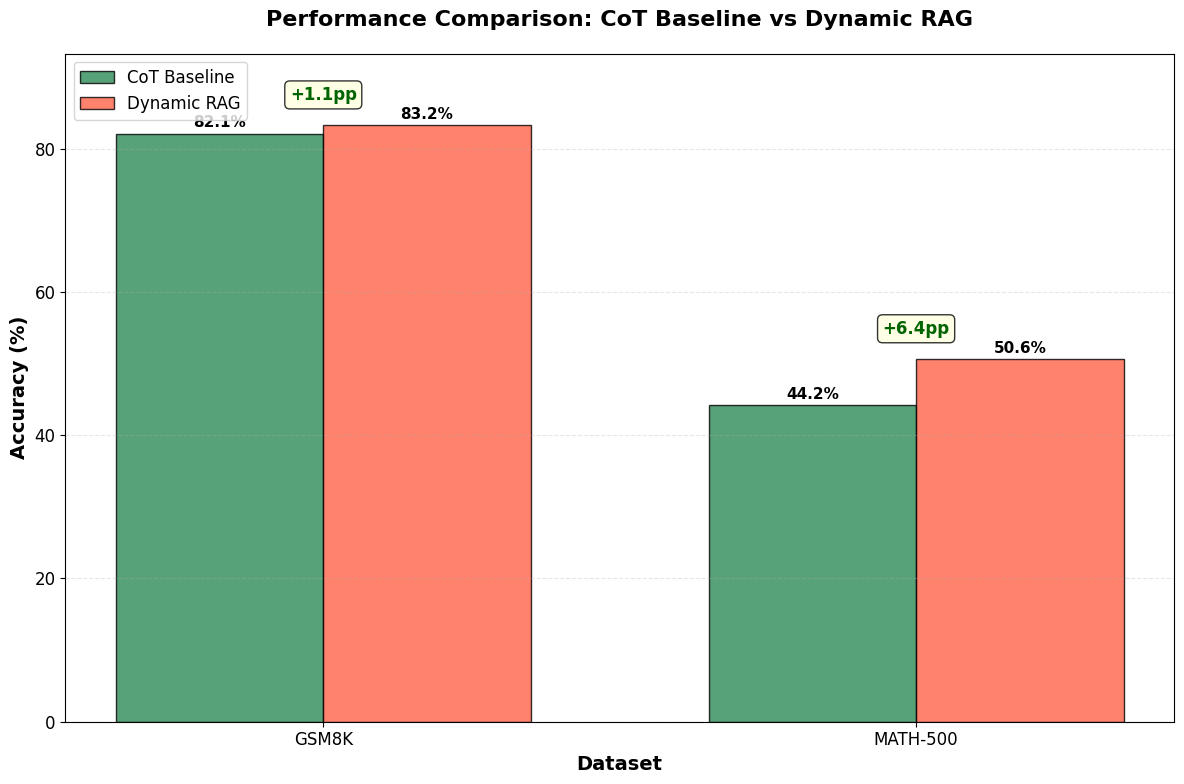

📈 CoT vs Dynamic RAG Analysis:
• Dynamic RAG consistently outperforms CoT baseline on both datasets
• Average improvement: +3.8pp
• Larger gains on MATH-500 (harder problems) demonstrate adaptive retrieval value


In [8]:
# Figure 1: CoT Baseline vs Dynamic RAG Comparison
plt.figure(figsize=(12, 8))

x = np.arange(len(datasets_display))
width = 0.35

# Create bars for CoT vs Dynamic comparison
bars1 = plt.bar(x - width/2, cot_scores, width, label='CoT Baseline', 
                color='#2E8B57', alpha=0.8, edgecolor='black', linewidth=1)
bars2 = plt.bar(x + width/2, dynamic_scores, width, label='Dynamic RAG', 
                color='#FF6347', alpha=0.8, edgecolor='black', linewidth=1)

# Customize the plot
plt.xlabel('Dataset', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.title('Performance Comparison: CoT Baseline vs Dynamic RAG', 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(x, datasets_display, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add improvement indicators
for i in range(len(datasets_display)):
    improvement = dynamic_scores[i] - cot_scores[i]
    plt.annotate(f'+{improvement:.1f}pp', xy=(i, max(cot_scores[i], dynamic_scores[i]) + 3), 
                ha='center', va='bottom', fontweight='bold', color='darkgreen', 
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim(0, max(max(cot_scores), max(dynamic_scores)) + 10)

plt.tight_layout()
plt.show()

print("📈 CoT vs Dynamic RAG Analysis:")
print("• Dynamic RAG consistently outperforms CoT baseline on both datasets")
avg_improvement = np.mean([dynamic_scores[i] - cot_scores[i] for i in range(len(datasets_display))])
print(f"• Average improvement: +{avg_improvement:.1f}pp")
print("• Larger gains on MATH-500 (harder problems) demonstrate adaptive retrieval value")

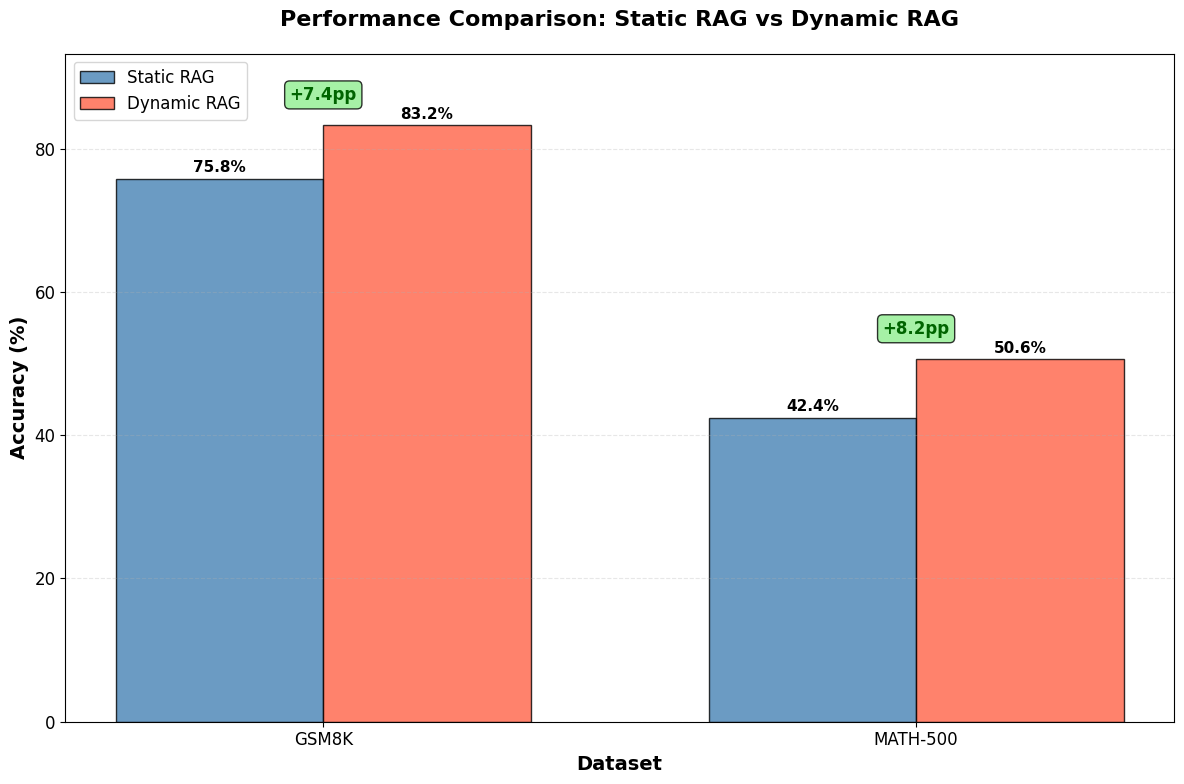

📈 Static vs Dynamic RAG Analysis:
• Dynamic RAG dramatically outperforms static retrieval approach
• Average improvement: +7.8pp
• Demonstrates critical importance of adaptive retrieval decision-making
• Static retrieval can actually hurt performance vs no retrieval


In [9]:
# Figure 2: Static RAG vs Dynamic RAG Comparison
plt.figure(figsize=(12, 8))

x = np.arange(len(datasets_display))
width = 0.35

# Create bars for Static vs Dynamic comparison
bars1 = plt.bar(x - width/2, static_scores, width, label='Static RAG', 
                color='#4682B4', alpha=0.8, edgecolor='black', linewidth=1)
bars2 = plt.bar(x + width/2, dynamic_scores, width, label='Dynamic RAG', 
                color='#FF6347', alpha=0.8, edgecolor='black', linewidth=1)

# Customize the plot
plt.xlabel('Dataset', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.title('Performance Comparison: Static RAG vs Dynamic RAG', 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(x, datasets_display, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add improvement indicators
for i in range(len(datasets_display)):
    improvement = dynamic_scores[i] - static_scores[i]
    plt.annotate(f'+{improvement:.1f}pp', xy=(i, max(static_scores[i], dynamic_scores[i]) + 3), 
                ha='center', va='bottom', fontweight='bold', color='darkgreen', 
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim(0, max(max(static_scores), max(dynamic_scores)) + 10)

plt.tight_layout()
plt.show()

print("📈 Static vs Dynamic RAG Analysis:")
print("• Dynamic RAG dramatically outperforms static retrieval approach")
avg_improvement = np.mean([dynamic_scores[i] - static_scores[i] for i in range(len(datasets_display))])
print(f"• Average improvement: +{avg_improvement:.1f}pp")
print("• Demonstrates critical importance of adaptive retrieval decision-making")
print("• Static retrieval can actually hurt performance vs no retrieval")

In [10]:
# Get best dynamic variants for detailed analysis
gsm_best_variant = best_variants['gsm8k']
math_best_variant = best_variants['math500']

# GSM8K Category Analysis
print("\n🔍 GSM8K Categories:")
gsm_cot_df = runs["cot"]["gsm8k"]
gsm_llm_df = runs["llm"]["gsm8k"]
gsm_static_df = runs["static"]["gsm8k"] 
gsm_dynamic_df = runs["dynamic"]["gsm8k"][gsm_best_variant]

gsm_category_results = []
for category in gsm_cot_df['category'].unique():
    if pd.isna(category):
        continue

    llm_acc = gsm_llm_df[gsm_llm_df['category'] == category]['is_correct'].mean() * 100
    cot_acc = gsm_cot_df[gsm_cot_df['category'] == category]['is_correct'].mean() * 100
    static_acc = gsm_static_df[gsm_static_df['category'] == category]['is_correct'].mean() * 100
    dynamic_acc = gsm_dynamic_df[gsm_dynamic_df['category'] == category]['is_correct'].mean() * 100
    
    gsm_category_results.append({
        'Category': category,
        'LLM': f'{llm_acc:.1f}%',
        'CoT': f'{cot_acc:.1f}%',
        'Static RAG': f'{static_acc:.1f}%', 
        'Dynamic RAG': f'{dynamic_acc:.1f}%',
        'Dynamic vs CoT': f'{dynamic_acc - cot_acc:+.1f}pp',
        'Dynamic vs Static': f'{dynamic_acc - static_acc:+.1f}pp'
    })

gsm_cat_df = pd.DataFrame(gsm_category_results)
display(gsm_cat_df)

# MATH-500 Category Analysis  
print("\n🔍 MATH-500 Categories:")
math_cot_df = runs["cot"]["math500"]
math_llm_df = runs["llm"]["math500"]
math_static_df = runs["static"]["math500"]
math_dynamic_df = runs["dynamic"]["math500"][math_best_variant]

math_category_results = []
for category in math_cot_df['category'].unique():
    if pd.isna(category):
        continue
    
    llm_acc = math_llm_df[math_llm_df['category'] == category]['is_correct'].mean() * 100
    cot_acc = math_cot_df[math_cot_df['category'] == category]['is_correct'].mean() * 100
    static_acc = math_static_df[math_static_df['category'] == category]['is_correct'].mean() * 100
    dynamic_acc = math_dynamic_df[math_dynamic_df['category'] == category]['is_correct'].mean() * 100
    
    math_category_results.append({
        'Category': category,
        'LLM': f'{llm_acc:.1f}%',
        'CoT': f'{cot_acc:.1f}%',
        'Static RAG': f'{static_acc:.1f}%',
        'Dynamic RAG': f'{dynamic_acc:.1f}%', 
        'Dynamic vs CoT': f'{dynamic_acc - cot_acc:+.1f}pp',
        'Dynamic vs Static': f'{dynamic_acc - static_acc:+.1f}pp'
    })

math_cat_df = pd.DataFrame(math_category_results)
display(math_cat_df)


🔍 GSM8K Categories:


,Category,LLM,CoT,Static RAG,Dynamic RAG,Dynamic vs CoT,Dynamic vs Static
0,Money & Finance,48.4%,79.2%,69.7%,80.6%,+1.4pp,+10.9pp
1,Other,43.8%,89.9%,85.7%,89.4%,-0.5pp,+3.7pp
2,Geometry & Measurement,37.0%,83.6%,79.5%,87.7%,+4.1pp,+8.2pp
3,Rates & Work,43.9%,82.4%,77.5%,84.0%,+1.6pp,+6.4pp
4,Time & Scheduling,40.5%,78.6%,74.2%,81.0%,+2.4pp,+6.7pp
5,Fractions & Ratios,48.7%,82.1%,66.7%,76.9%,-5.1pp,+10.3pp
6,Logic & Number Puzzles,35.0%,85.5%,82.1%,85.5%,+0.0pp,+3.4pp
7,Counting & Combinatorics,50.0%,50.0%,50.0%,50.0%,+0.0pp,+0.0pp



🔍 MATH-500 Categories:


,Category,LLM,CoT,Static RAG,Dynamic RAG,Dynamic vs CoT,Dynamic vs Static
0,Precalculus,23.2%,23.2%,21.4%,32.1%,+8.9pp,+10.7pp
1,Intermediate Algebra,22.7%,30.9%,29.9%,34.0%,+3.1pp,+4.1pp
2,Algebra,46.0%,65.3%,61.3%,63.7%,-1.6pp,+2.4pp
3,Number Theory,21.0%,37.1%,43.5%,53.2%,+16.1pp,+9.7pp
4,Prealgebra,35.4%,58.5%,58.5%,68.3%,+9.8pp,+9.8pp
5,Geometry,22.0%,39.0%,31.7%,48.8%,+9.8pp,+17.1pp
6,Counting & Probability,15.8%,26.3%,18.4%,36.8%,+10.5pp,+18.4pp



🎚️ MATH-500 Difficulty Analysis:


,Difficulty,LLM,CoT,Static RAG,Dynamic RAG,Retrieval Rate,Dynamic vs CoT,Dynamic vs Static
0,Level 1,51.2%,72.1%,76.7%,86.0%,14.0%,+14.0pp,+9.3pp
1,Level 2,44.4%,60.0%,63.3%,67.8%,21.1%,+7.8pp,+4.4pp
2,Level 3,37.1%,52.4%,49.5%,61.9%,33.3%,+9.5pp,+12.4pp
3,Level 4,21.9%,38.3%,32.0%,47.7%,41.4%,+9.4pp,+15.6pp
4,Level 5,14.9%,23.9%,21.6%,21.6%,60.4%,-2.2pp,+0.0pp


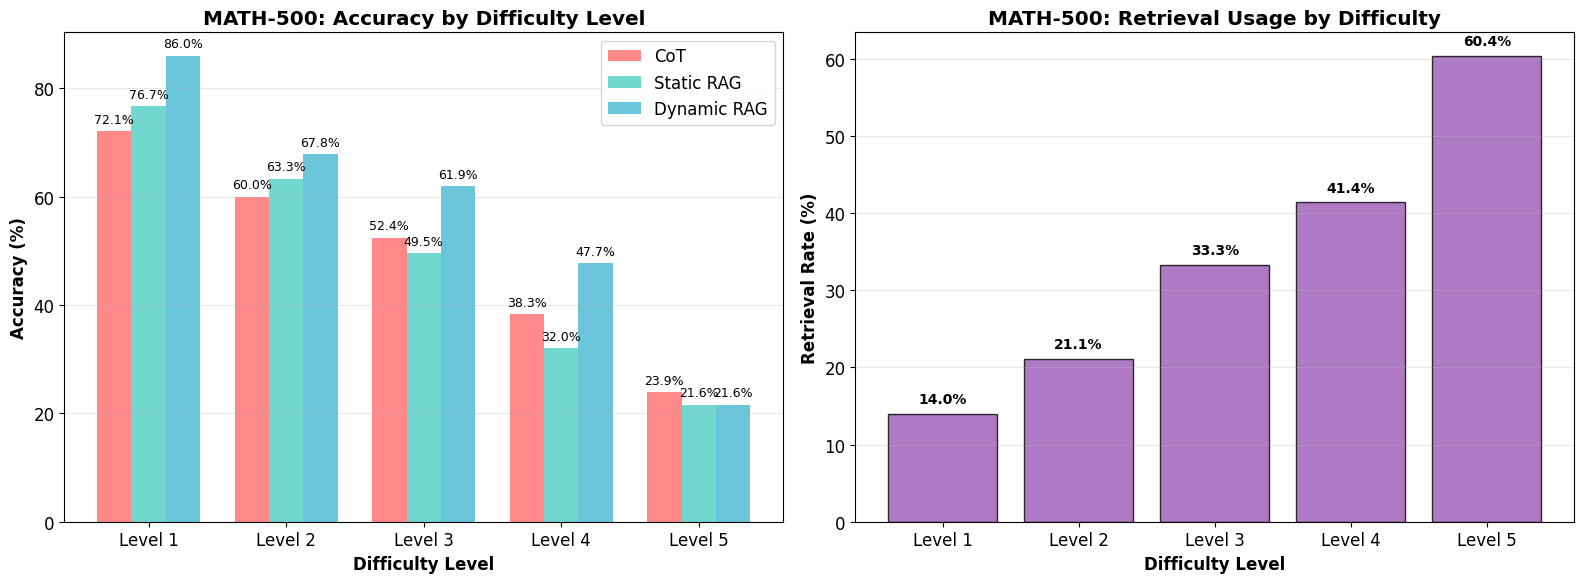

In [11]:
# MATH-500 has proper difficulty levels (Level 1-5)
print("\n🎚️ MATH-500 Difficulty Analysis:")
math_difficulties = ['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5']
math_diff_results = []

for level in math_difficulties:
    # Filter by difficulty level
    llm_level = math_llm_df[math_llm_df['difficulty'] == level]
    cot_level = math_cot_df[math_cot_df['difficulty'] == level]
    static_level = math_static_df[math_static_df['difficulty'] == level]
    dynamic_level = math_dynamic_df[math_dynamic_df['difficulty'] == level]
    
    if len(cot_level) > 0:
        llm_acc = llm_level['is_correct'].mean() * 100
        cot_acc = cot_level['is_correct'].mean() * 100
        static_acc = static_level['is_correct'].mean() * 100
        dynamic_acc = dynamic_level['is_correct'].mean() * 100
        retrieval_rate = dynamic_level['retrieval_executed'].mean() * 100
        
        math_diff_results.append({
            'Difficulty': level,
            'LLM': f'{llm_acc:.1f}%',
            'CoT': f'{cot_acc:.1f}%',
            'Static RAG': f'{static_acc:.1f}%',
            'Dynamic RAG': f'{dynamic_acc:.1f}%',
            'Retrieval Rate': f'{retrieval_rate:.1f}%',
            'Dynamic vs CoT': f'{dynamic_acc - cot_acc:+.1f}pp',
            'Dynamic vs Static': f'{dynamic_acc - static_acc:+.1f}pp'
        })

math_diff_df = pd.DataFrame(math_diff_results)
display(math_diff_df)

# Create difficulty visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Extract data for plotting
levels = [r['Difficulty'] for r in math_diff_results]
llm_scores = [float(r['LLM'].rstrip('%')) for r in math_diff_results]
cot_scores = [float(r['CoT'].rstrip('%')) for r in math_diff_results]
static_scores = [float(r['Static RAG'].rstrip('%')) for r in math_diff_results]
dynamic_scores = [float(r['Dynamic RAG'].rstrip('%')) for r in math_diff_results]
retrieval_rates = [float(r['Retrieval Rate'].rstrip('%')) for r in math_diff_results]

# Plot 1: Accuracy by Difficulty
x_pos = np.arange(len(levels))
width = 0.25

bars1 = ax1.bar(x_pos - width, cot_scores, width, label='CoT', color='#FF6B6B', alpha=0.8)
bars2 = ax1.bar(x_pos, static_scores, width, label='Static RAG', color='#4ECDC4', alpha=0.8)
bars3 = ax1.bar(x_pos + width, dynamic_scores, width, label='Dynamic RAG', color='#45B7D1', alpha=0.8)

ax1.set_xlabel('Difficulty Level', fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontweight='bold')
ax1.set_title('MATH-500: Accuracy by Difficulty Level', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(levels)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Retrieval Rate by Difficulty
bars_ret = ax2.bar(x_pos, retrieval_rates, color='#9B59B6', alpha=0.8, edgecolor='black')
ax2.set_xlabel('Difficulty Level', fontweight='bold')
ax2.set_ylabel('Retrieval Rate (%)', fontweight='bold')
ax2.set_title('MATH-500: Retrieval Usage by Difficulty', fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(levels)
ax2.grid(axis='y', alpha=0.3)


# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

for bar in bars_ret:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()
